In [1]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torch.nn.functional import cosine_similarity
import torch.optim as optim
import torch.nn as nn

d:\Projects\sentence-transformers-multi-task-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1

In [3]:
# Auto-detect device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load both models
model_small = SentenceTransformer('all-MiniLM-L6-v2', device=device)
model_large = SentenceTransformer('all-mpnet-base-v2', device=device)

# Sample sentences for Formula 1 and Football
sentences = [
    "Formula 1 is the pinnacle of motorsport, featuring the fastest cars and most skilled drivers.",
    "The World Cup is the most prestigious tournament in international football, drawing massive global audiences.",
    "Lewis Hamilton secured his seventh Formula 1 World Championship, tying the all-time record.",
    "The Champions League final showcased a thrilling match between two of Europe's top football clubs.",
    "Advancements in aerodynamics have significantly improved the performance of modern Formula 1 cars."
]

# Generate embeddings using both models
embeddings_small = model_small.encode(sentences, convert_to_tensor=True)
embeddings_large = model_large.encode(sentences, convert_to_tensor=True)

# Compute cosine similarities between related sentences
def compute_similarity(embeddings):
    sim_scores = []
    pairs = [(0, 2), (1, 3), (0, 4)]  # Pairs of indices to compare
    for i, j in pairs:
        sim = cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0)).item()
        sim_scores.append((i, j, sim))
    return sim_scores

similarities_small = compute_similarity(embeddings_small)
similarities_large = compute_similarity(embeddings_large)

# Display similarity comparisons
print("Similarity scores (all-MiniLM-L6-v2):")
for i, j, score in similarities_small:
    print(f"Sentences {i} & {j}: {score:.4f}")

print("\nSimilarity scores (all-mpnet-base-v2):")
for i, j, score in similarities_large:
    print(f"Sentences {i} & {j}: {score:.4f}")


Similarity scores (all-MiniLM-L6-v2):
Sentences 0 & 2: 0.5262
Sentences 1 & 3: 0.3987
Sentences 0 & 4: 0.6494

Similarity scores (all-mpnet-base-v2):
Sentences 0 & 2: 0.5365
Sentences 1 & 3: 0.3083
Sentences 0 & 4: 0.6278


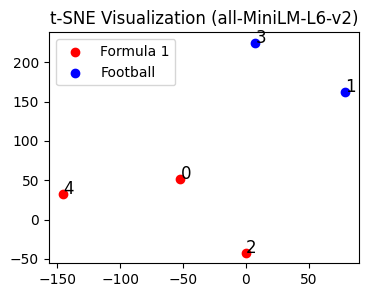

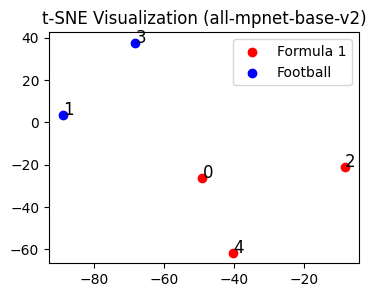

In [4]:
# Perform t-SNE for visualization
def plot_embeddings(embeddings, title):
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings.cpu().numpy())
    
    labels = ["Formula 1", "Football", "Formula 1", "Football", "Formula 1"]
    colors = ["red" if "Formula" in label else "blue" for label in labels]
    
    plt.figure(figsize=(4, 3))
    for i, label in enumerate(labels):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], c=colors[i], label=label if label not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1], str(i), fontsize=12)
    
    plt.title(title)
    plt.legend()
    plt.show()

# Plot both models' embeddings
plot_embeddings(embeddings_small, "t-SNE Visualization (all-MiniLM-L6-v2)")
plot_embeddings(embeddings_large, "t-SNE Visualization (all-mpnet-base-v2)")

### Sentence Transformer Model Comparison

| Feature                | all-MiniLM-L6-v2           | all-mpnet-base-v2       |
|------------------------|--------------------------|--------------------------|
| ***Backbone***       | MiniLM (Miniature BERT)       | MPNet (Masked and Permuted Transformer) |
| **Number of Parameters** | ~22M                    | ~110M                    |
| **Encoder Layers**     | 6                      | 12                      |
| **Embedding Size**     | 384                      | 768                      |
| **Speed**             | Faster                 | Slower                 |
| **Memory Usage**      | Lower         | Higher        |
| **Sentence Similarity** | More generalized        | More fine-grained        |
| **Semantic Accuracy** | Moderate                 | Higher                    |
| **t-SNE Visualization**          | generalizes concepts more loosely | better-separated clusters |

Note*: To get embeddings, every single one of these layers must be traversed. 

__Each Encoder layer consists of:__
1. Self-attention mechanism
2. Feedforward network
3. Normalization layers

### Comparing the models 
Both all-MiniLM-L6-v2 and all-mpnet-base-v2 perform well in capturing the semantic similarities between sentences, but there are some key differences:
1. Slightly Higher Similarity in Larger Model
    - The larger mpnet-base-v2 model consistently shows slightly higher similarity scores (e.g., 0.5365 vs. 0.5262 for Sentences 0 & 2). This suggests it captures richer semantic relationships, likely due to a larger model size and more expressive embeddings.
2. Greater Contrast in Football Sentences
    - The smaller model assigns higher similarity (0.3987) between the football-related sentences, while the larger model assigns 0.3083. This suggests mpnet-base-v2 is better at distinguishing contextually different statements, possibly due to better generalization and nuanced token representations.
3. Aerodynamics Example Shows Slight Drop in Larger Model
    - For Sentences 0 & 4 (both Formula 1-related), MiniLM scored 0.6494, while mpnet-base scored 0.6278. This minor drop suggests MiniLM might slightly overestimate similarity in domain-specific content, while mpnet-base keeps it more refined.

### Conlusion
I will be using the smaller model to keep things light and fast. 

While the backbone is responsible for token-level embeddings, other architectural choices influence the quality and performance of sentence embeddings:
- __Pooling Strategy:__ Transformers generate word-level embeddings, but we need a single fixed-length vector per sentence. Mean pooling (mean-over-time) is applied to aggregate token embeddings. It captures information from all tokens rather than relying on a single token.

# Task 2

Expanding a sentence transformer into a multi-task learning (MTL) setup involves using the same transformer backbone for multiple NLP tasks while adding task-specific heads for each task. This allows the model to learn generalized sentence representations while fine-tuning on different downstream tasks.

```bash
                     --------------------------  
                     |  Transformer Backbone  |  <-- **Shared Encoder (Frozen or Fine-Tuned)**
                     --------------------------   
                               |  
          -------------------------------------------  
          |                                         |  
-------------------------                 -------------------------   
|   Sentence Classifier |                 |  Sentiment Classifier |  
|   (Task A Head)       │                 |  (Task B Head)        |  
-------------------------                 -------------------------   

```

- The transformer backbone encodes input sentences into fixed-length vector representations.
- These embeddings are then passed to separate classification heads.
- Both heads are fully connected (linear) layers that take the sentence embeddings from the transformer and map them to output classes. More layers can be added to the heads if there is a lot of training data.

Each head consists of a linear transformation (nn.Linear). This applies a weight matrix and bias to project the embeddings to the desired class space.
Mathematically:
```sh
    logits = W ⋅ embedding + b

where:
    - W is the weight matrix of shape (num_classes × embedding_dim)
    - b is the bias of shape (num_classes)
    - embedding is the input sentence embedding of shape (batch_size × embedding_dim).
```

The only trainable parameters are the weights and biases of the two linear layers:
- Sentence Classification Head (`nn.Linear(384, 2)`)
    - Trainable parameters: (2 × 384) + 2 = 770 parameters
- Sentiment Analysis Head (`nn.Linear(384, 3)`)
    - Trainable parameters: (3 × 384) + 3 = 1155 parameters

__Shared and Task-Specific Learning__
- The transformer backbone learns generalized language features (e.g., sentence meaning, structure).
- Task-specific heads fine-tune these embeddings for specialized NLP tasks.
- During training, a joint loss function optimizes both tasks simultaneously.

## Task 3

When training a multi-task learning model with a shared transformer backbone and task-specific heads, different freezing strategies impact model performance, efficiency, and generalization. 

### Case 1: If the entire network is frozen
When the entire network is frozen, including both the transformer backbone and task-specific heads, no parameters are updated, meaning the model isn't actually "learning" in the traditional sense. Further:
- The model only performs inference using pre-trained weights.
- The gradient updates do not happen, since all layers are frozen.
- The classification heads remain fixed, using whatever initial (or pre-trained) weights they have.

This would make sense only if we are using the model as a pure feature extractor. Where we simply extract embeddings from the frozen model. These embeddings can be used for other downstream models (e.g., a separate logistic regression classifier).

### Case 2: If Only the Transformer Backbone is Frozen
This approach freezes the transformer backbone while training only the task-specific heads. The transformer backbone remains unchanged which means that the Pre-trained embeddings from the transformer are used as fixed representations. By only training the task specific heads, these layers learn how to best interpret the frozen embeddings for tasks. 

__Advantages__
- __Efficient Training:__ Since most of the model is frozen, far fewer parameters are updated, leading to faster training and lower GPU memory usage.
- __Prevents Catastrophic Forgetting:__ The transformer retains its general knowledge while the task-specific heads specialize in new tasks.
- __Stable Representations:__ The transformer embeddings remain consistent across different runs, which can help with reproducibility.

The only douwside to this method is the fixed embeddings might limit the performance if they do not capture task-relevant distinctions well.

### Case 3: If Only One Task-Specific Head is Frozen
The transformer backbone is fine-tuned, but one of the task-specific heads (either Sentence Classification or Sentiment Analysis) remains frozen and does not learn anything new, while the other continues training, adapting to the task. The model learns new representations at the transformer level. But the frozen head does not adjust, meaning it uses outdated embeddings that no longer match the newly fine-tuned backbone. The trained head benefits from both the updated backbone and task-specific fine-tuning.

This would only make sense if one task is already well-learned, freezing it ensures that fine-tuning the transformer doesn’t degrade its performance. 

### Conclusion:
The best case for applying transfer learning is Scenario 2: Freezing the Transformer Backbone While Training Only the Task-Specific Heads. This is a highly efficient and practical approach when adapting a pre-trained model to a new task with limited data.
1. Pretrained Model used will be `all-MiniLM-L6-v2`. 
2. `Freeze the transformer backbone and train the classification heads for sentence classification and sentiment analysis downstream tasks`.
3. The `all-MiniLM-L6-v2` sentence trasnformer model is good enough to capture the semantic meaning in a sentence. Along with that is it light and fast to use for demonstration. Freezing the transformer backbone is ideal here because the pre-trained backbone already understands sentence structure, so we don’t need to fine-tune it. Training only the classification heads reduces GPU memory and speeds up training. It also prevents overfitting which would have occured if we finetuned that backbone with small dataset.
4. One fully connected layer is enough with the small training dataset. The heads can be made deeper when the training data is increased.

## Task 4

### Evaluation Metric
For evaluating the training loop, I have chosen simple accuracy metric. F1 score is generally considered a better metric than accuracy when dealing with imbalanced data because it takes into account both precision and recall, providing a more robust evaluation of model performance, especially when one class is significantly outnumbered by the other; whereas accuracy can be misleading in such scenarios. But since the dataset is small, we can use accuracy for it. 
- For Classification problem, it is how accurately the model distinguishes between Sports (label 0) and Politics (label 1).
- For sentiment analysis problem, it is how accuractely model classifies sentences into Negative (0), Neutral (1), or Positive (2).

### Loss Function
The model uses CrossEntropyLoss, which is commonly used for multi-class classification tasks. Since both tasks involve categorical classification (Sports vs. Politics, and Sentiment Analysis), CrossEntropyLoss is suitable. 

CrossEntropyLoss works by comparing the true class labels to the predicted probability distribution and penalizing incorrect predictions. It ensures that the model assigns high probabilities to the correct class while minimizing the probabilities of incorrect ones.

For multi-task learning, to ensure that both tasks contribute to training, the total loss is:
```sh
𝐿 total = 𝐿 classification + 𝐿 sentiment ​
```
This means that both classification and sentiment analysis contribute to training, ensuring that the model learns useful representations for both tasks.

### Optimizer
Adam is a great choice for optimizing deep learning models because it combines the __best of both worlds: momentum and RMSProp__. Momentum helps accelerate learning by smoothing out updates, while RMSProp adapts the learning rate for each parameter individually, making it more stable.

Another big advantage is that Adam handles sparse gradients well, which is particularly useful for transformer-based models like `all-MiniLM-L6-v2`. Since transformers operate on large, high-dimensional text embeddings, some gradients can be very small or infrequent—Adam adjusts efficiently to these variations.

Finally, Adam is widely used in NLP tasks because it's computationally efficient and requires minimal tuning, making it a solid default choice for fine-tuning sentence transformers.

### Forward Pass
The forward pass is the process where input data flows through the model to produce predictions. In our case, we have:
- Sentence embeddings extraction
    - The input sentences are encoded using the MiniLM transformer (all-MiniLM-L6-v2).
    - These embeddings are 384-dimensional vectors representing each sentence in a dense space.
- Task-Specific Predictions: The embeddings are passed through two separate classification heads:
    - Sentence Classification Head (nn.Linear(384, 2)) → Predicts if the sentence is Sports or Politics.
    - Sentiment Analysis Head (nn.Linear(384, 3)) → Predicts if the sentiment is Negative, Neutral, or Positive.
- Logits Output
    - Each classification head produces logits (raw scores before softmax).
    - These logits are passed to the CrossEntropyLoss, which applies softmax internally and calculates how far the predictions are from the true labels.

### Conclusion
- The forward pass ensures efficient, task-specific learning while leveraging shared sentence embeddings.
- For evaluating the model, accuracy is used since the dataset is balanced.  
- The CrossEntropyLoss is chosen because both tasks involve multi-class classification. Since this is a multi-task learning setup, the total loss is simply the sum of classification and sentiment losses, making sure both tasks contribute to training.
- To optimize the model, we use Adam, which is well-suited for transformer-based NLP models. It combines momentum for stability and adaptive learning rates for efficiency, making it ideal for handling high-dimensional embeddings.


In [5]:
# Load transformer backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

class MultiTaskModel(nn.Module):
    """
    Multi-task learning model with a shared transformer backbone.
        - Task A: Sentence Classification (e.g., Sports vs. Politics)
        - Task B: Sentiment Analysis (Negative, Neutral, Positive)
    """
    def __init__(self, base_model, num_classes_taskA=2, num_classes_taskB=3):
        """
        Initializes the multi-task learning model with a shared transformer backbone 
        and separate classification heads for sentence classification and sentiment analysis.
        """
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model  # Shared transformer encoder

        # Freeze Transformer Backbone
        for param in self.base_model.parameters():
            param.requires_grad = False  # Keeping transformer frozen

        embedding_dim = base_model.get_sentence_embedding_dimension()
        
        # Task-Specific Heads
        self.taskA_classifier = nn.Linear(embedding_dim, num_classes_taskA)  # Sentence Classification
        self.taskB_sentiment = nn.Linear(embedding_dim, num_classes_taskB)  # Sentiment Analysis
        
    def forward(self, sentence_embeddings):
        """
        Forward pass of the multi-task learning model.
        """
        logits_taskA = self.taskA_classifier(sentence_embeddings)
        logits_taskB = self.taskB_sentiment(sentence_embeddings)
        return logits_taskA, logits_taskB

# Initiating the multi-task learning model
multi_task_model = MultiTaskModel(model).to(device)

In [6]:
# Define Multi-Task Loss & Optimizer
criterion_taskA = nn.CrossEntropyLoss()  # Loss for Sentence Classification
criterion_taskB = nn.CrossEntropyLoss()  # Loss for Sentiment Analysis
optimizer = optim.Adam(multi_task_model.parameters(), lr=2e-3)

In [7]:
# Example Sentences (30 samples, 15 per category with 5 negative, 5 neutral, 5 positive)
sentences = [
    # Sports (5 Negative, 5 Neutral, 5 Positive)
    "The Lakers suffered a devastating defeat in the NBA playoffs.",
    "Cristiano Ronaldo's missed penalty cost his team the match.",
    "The Olympics faced multiple organizational issues this year.",
    "A major doping scandal shook the athletics world.",
    "The FIFA World Cup final was overshadowed by referee controversies.",
    "The team's performance was average, neither too great nor too bad.",
    "The new rule changes brought mixed reactions from players and coaches.",
    "The match ended in a goalless draw after extra time.",
    "The new stadium is under construction and expected to open next year.",
    "The player’s transfer to another club is still under negotiation.",
    "Lewis Hamilton won the Formula 1 Grand Prix.",
    "Max Verstappen dominated the F1 season with multiple wins.",
    "Ferrari showed impressive speed improvements this season.",
    "The Monaco Grand Prix remains one of the most prestigious races in F1.",
    "Mercedes successfully implemented a new aerodynamic package.",
    # Politics (5 Negative, 5 Neutral, 5 Positive)
    "The Supreme Court ruling sparked nationwide protests.",
    "A diplomatic scandal led to tensions between countries.",
    "The government’s response to the crisis was heavily criticized.",
    "Voter suppression concerns rise ahead of the national elections.",
    "Public dissatisfaction with leadership is at an all-time high.",
    "The President delivered a speech on economic reform.",
    "Congress passed a new climate change bill this week.",
    "The United Nations is hosting a summit on global security.",
    "A major political debate took place ahead of the elections.",
    "New policies on immigration were announced today.",
    "The country saw significant economic growth this quarter.",
    "A peace agreement was signed after months of negotiations.",
    "The government launched a new initiative to improve education.",
    "International cooperation led to a breakthrough in trade relations.",
    "The infrastructure project was completed ahead of schedule."
]

In [8]:
# Labels for Task A (Sentence Classification)
labels_taskA = torch.tensor([0]*15 + [1]*15, device=device)  # 0 = Sports, 1 = Politics

# Labels for Task B (Sentiment Analysis)
labels_taskB = torch.tensor([
    0, 0, 0, 0, 0,  # Sports Negative
    1, 1, 1, 1, 1,  # Sports Neutral
    2, 2, 2, 2, 2,  # Sports Positive
    0, 0, 0, 0, 0,  # Politics Negative
    1, 1, 1, 1, 1,  # Politics Neutral
    2, 2, 2, 2, 2   # Politics Positive
], device=device)

In [9]:
# Training Loop
epochs = 100
for epoch in range(epochs):
    multi_task_model.train()
    optimizer.zero_grad()
    
    # Convert sentences to embeddings (avoiding redundant encoding per iteration)
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True).to(device)
    
    # Forward Pass
    logits_A, logits_B = multi_task_model(sentence_embeddings)
    
    # Compute Loss
    loss_A = criterion_taskA(logits_A, labels_taskA)
    loss_B = criterion_taskB(logits_B, labels_taskB)
    total_loss = loss_A + loss_B  # Multi-task Joint Loss
    
    # Backward Pass and Optimization
    total_loss.backward()
    optimizer.step()
    
    # Compute Accuracy Metrics
    acc_A = (torch.argmax(logits_A, dim=1) == labels_taskA).float().mean().item()
    acc_B = (torch.argmax(logits_B, dim=1) == labels_taskB).float().mean().item()
    
    # Print every 10 epochs for cleaner output
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss A: {loss_A.item():.4f} | Loss B: {loss_B.item():.4f} | Total Loss: {total_loss.item():.4f} | Acc A: {acc_A:.4f} | Acc B: {acc_B:.4f}")


Epoch 10 | Loss A: 0.6244 | Loss B: 1.0161 | Total Loss: 1.6404 | Acc A: 1.0000 | Acc B: 0.9667
Epoch 20 | Loss A: 0.5496 | Loss B: 0.9344 | Total Loss: 1.4839 | Acc A: 1.0000 | Acc B: 0.9333
Epoch 30 | Loss A: 0.4847 | Loss B: 0.8594 | Total Loss: 1.3441 | Acc A: 1.0000 | Acc B: 0.9667
Epoch 40 | Loss A: 0.4292 | Loss B: 0.7910 | Total Loss: 1.2202 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 50 | Loss A: 0.3819 | Loss B: 0.7289 | Total Loss: 1.1109 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 60 | Loss A: 0.3416 | Loss B: 0.6727 | Total Loss: 1.0143 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 70 | Loss A: 0.3071 | Loss B: 0.6218 | Total Loss: 0.9290 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 80 | Loss A: 0.2775 | Loss B: 0.5758 | Total Loss: 0.8532 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 90 | Loss A: 0.2518 | Loss B: 0.5340 | Total Loss: 0.7858 | Acc A: 1.0000 | Acc B: 1.0000
Epoch 100 | Loss A: 0.2295 | Loss B: 0.4961 | Total Loss: 0.7256 | Acc A: 1.0000 | Acc B: 1.0000


### Testing the model

In [10]:
test_sentences = [
    "Chelsea secured a last-minute victory in the Champions League.",  # Sports
    "Max Verstappen beat Lewis Hamiltion in the last lap of the Abu Dhabi Grand Prix in 2021.",  # Sports
    "The home team suffered a devastating loss in the final match.",  # Sports (Negative)
    "The Senate is set to vote on a controversial healthcare bill.",  # Politics
    "World leaders gathered for a summit on climate change policies.",  # Politics
    "The country's economy is struggling due to poor government policies."  # Politics (Negative)
]


multi_task_model.eval()  # Set model to evaluation mode
sentence_embeddings = model.encode(test_sentences, convert_to_tensor=True)
sentence_embeddings = sentence_embeddings.unsqueeze(0) if sentence_embeddings.dim() == 1 else sentence_embeddings
sentence_embeddings = sentence_embeddings.to(device)

In [11]:
with torch.no_grad():
    logits_A, logits_B = multi_task_model(sentence_embeddings)

    predicted_taskA = torch.argmax(logits_A, dim=-1).cpu().detach().numpy().tolist()
    predicted_taskB = torch.argmax(logits_B, dim=-1).cpu().detach().numpy().tolist()

print("Predicted Categories (0=Sports, 1=Politics):", predicted_taskA)
print("Predicted Sentiments (0=Negative, 1=Neutral, 2=Positive):", predicted_taskB)


Predicted Categories (0=Sports, 1=Politics): [0, 0, 0, 1, 1, 1]
Predicted Sentiments (0=Negative, 1=Neutral, 2=Positive): [2, 2, 0, 1, 1, 0]
